In [76]:
import numpy as np
import pandas as pd
from pandas import DataFrame, option_context
from rateslib import dt, add_tenor
from rateslib.curves import Curve
from rateslib.instruments import IRS
from rateslib.solver import Solver
import matplotlib.pyplot as plt
from pathlib import Path

repo_root = Path.cwd()
csv_path = repo_root / "SOFR_panel_Date_Tenor_Rate_sorted.csv"

panel_long = pd.read_csv(csv_path, parse_dates=["Date"])

panel_long["Date"] = panel_long["Date"].dt.date

def sofr_curve(date_):
    """
    Return the SOFR curve (Tenor, Rate) for a given date.
    `date_` can be 'YYYY-MM-DD', datetime.date, or pd.Timestamp.
    """
    if isinstance(date_, str):
        date_ = pd.to_datetime(date_).date()
    elif isinstance(date_, pd.Timestamp):
        date_ = date_.date()

    return panel_long[panel_long["Date"] == date_].reset_index(drop=True)

data = sofr_curve("2025-11-14")
terms = data["Tenor"].astype(str).tolist()
rates = (data["Rate"]).astype(float).tolist() 

data = DataFrame({"Term": terms, "Rate": rates})

base_date = dt(2025, 11, 14)
settle_date = dt(2025, 11, 17) 

data["Termination"] = [add_tenor(settle_date, t, "F", "nyc") for t in data["Term"]]

sofr = Curve(
    id="sofr",
    convention="Act360",
    calendar="nyc",
    modifier="MF",
    interpolation="log_linear",
    nodes={
        base_date: 1.0, # <- today's DF 
        **{d: 1.0 for d in data["Termination"]},
    },
)

solver = Solver(
    curves=[sofr],
    instruments=[IRS(settle_date, d, spec="usd_irs", curves="sofr") for d in data["Termination"]],
    s=data["Rate"],
    instrument_labels=data["Term"],
    id="sofr_curve",
)

# Discount factors
data["DF"] = [float(sofr[d]) for d in data["Termination"]]
data["T_years"] = (data["Termination"] - base_date).dt.days / 365.0

# Zero continuo + zero annuale
data["Zero_cc"] = -np.log(data["DF"]) / data["T_years"]
data["Zero_annual"] = np.exp(data["Zero_cc"]) - 1.0

print("\n=== Curva: DF e tassi zero ===")
with option_context("display.float_format", lambda x: f"{x:.10f}"):
    print(data[["Term", "Rate", "T_years", "DF", "Zero_cc", "Zero_annual"]])

# Sanity check 1: NPV degli strumenti di calibrazione
sanity_inst = [
    IRS(
        settle_date, 
        d, 
        fixed_rate=r,  
        spec="usd_irs",
        curves="sofr"
    )
    for d, r in zip(data["Termination"], data["Rate"])
]

npvs = np.array([float(inst.npv(solver=solver)) for inst in sanity_inst])
print("Sanity #1 - NPV min/max/RMS:", npvs.min(), npvs.max(), np.sqrt((npvs**2).mean()))

# Sanity check 2: par rate impliciti
implied_rates = np.array([float(inst.rate(solver=solver)) for inst in sanity_inst])
diff_bps = (implied_rates - data["Rate"].values) * 100.0

print("Sanity #2 - max |diff| bps:", np.abs(diff_bps).max())

# Sanity check 3: monotonia DF
df_diff = np.diff(data["DF"].values)
print("Sanity #3 - max aumento DF:", df_diff.max())



SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 4.618279112617487e-16, `time`: 0.4841s

=== Curva: DF e tassi zero ===
   Term         Rate       T_years           DF      Zero_cc  Zero_annual
0    1W 3.9847395608  0.0273972603 0.9988941684 0.0403851882 0.0412117595
1    2W 3.9758490488  0.0465753425 0.9981248578 0.0402982006 0.0411211909
2    3W 3.9842259185  0.0657534247 0.9973501488 0.0403533084 0.0411785663
3    1M 3.9751225269  0.0904109589 0.9963675528 0.0402502155 0.0410712338
4    2M 3.9351901872  0.1835616438 0.9927231365 0.0397875550 0.0405896826
..  ...          ...           ...          ...          ...          ...
81  46Y 3.8477961539 46.0383561644 0.1837415647 0.0368002941 0.0374858081
82  47Y 3.8358703444 47.0410958904 0.1792788640 0.0365385362 0.0372142736
83  48Y 3.8231541980 48.0410958904 0.1752069352 0.0362561987 0.0369214704
84  49Y 3.8095411353 49.0465753425 0.1714823779 0.0359510273 0.0366050799
85  50Y 3.7948150217 50.0438356164 0

In [77]:
data["Termination"][0]

Timestamp('2025-11-24 00:00:00')

In [64]:
inst = IRS(base_date, data["Termination"][0], spec="usd_irs", curves="sofr")
fp = inst.leg2.periods[0]

print("Fixing method:", fp.fixing_method)
print("Spread compounding:", fp.spread_compound_method)
print("Period length :", (fp.end - fp.start).days, "days")
inst.cashflows(curves=sofr)

Fixing method: rfr_payment_delay
Spread compounding: none_simple
Period length : 7 days


,,Type,Period,Ccy,Acc Start,Acc End,Payment,Convention,DCF,Notional,DF,Collateral,Rate,Spread,Cashflow,NPV,FX Rate,NPV Ccy
leg1,0,FixedPeriod,Stub,USD,2025-11-14,2025-11-21,2025-11-25,act360,0.019444,1000000.0,0.998786,None,3.98474,NaN,-774.81047,-773.869823,1.0,-773.869823
leg2,0,FloatPeriod,Stub,USD,2025-11-14,2025-11-21,2025-11-25,act360,0.019444,-1000000.0,0.998786,None,3.98474,0.0,774.81047,773.869823,1.0,773.869823


In [65]:
tbl = fp.fixings_table(curve=sofr)
print(tbl.head(5))
print(tbl.tail(5))
print("Total fixings:", len(tbl))


                    sofr                              
                notional      risk       dcf     rates
obs_dates                                             
2025-11-14  9.995598e+05  0.832690  0.008333  3.983858
2025-11-17  9.998917e+05  0.277625  0.002778  3.983417
2025-11-18  1.000002e+06  0.277625  0.002778  3.983417
2025-11-19  1.000113e+06  0.277625  0.002778  3.983417
2025-11-20  1.000224e+06  0.277625  0.002778  3.983417
                    sofr                              
                notional      risk       dcf     rates
obs_dates                                             
2025-11-14  9.995598e+05  0.832690  0.008333  3.983858
2025-11-17  9.998917e+05  0.277625  0.002778  3.983417
2025-11-18  1.000002e+06  0.277625  0.002778  3.983417
2025-11-19  1.000113e+06  0.277625  0.002778  3.983417
2025-11-20  1.000224e+06  0.277625  0.002778  3.983417
Total fixings: 5


In [66]:
data

,Term,Rate,Termination,DF,T_years,Zero_cc,Zero_annual
0,1W,3.984740,2025-11-21,0.999226,0.019178,0.040385,0.041212
1,2W,3.975849,2025-11-28,0.998456,0.038356,0.040280,0.041102
2,3W,3.984226,2025-12-05,0.997681,0.057534,0.040349,0.041174
3,1M,3.975123,2025-12-15,0.996589,0.084932,0.040235,0.041055
4,2M,3.935190,2026-01-14,0.993376,0.167123,0.039766,0.040567
...,...,...,...,...,...,...,...
81,46Y,3.847796,2071-11-16,0.183765,46.035616,0.036800,0.037485
82,47Y,3.835870,2072-11-14,0.179339,47.032877,0.036538,0.037214
83,48Y,3.823154,2073-11-14,0.175265,48.032877,0.036255,0.036921
84,49Y,3.809541,2074-11-14,0.171574,49.032877,0.035950,0.036604


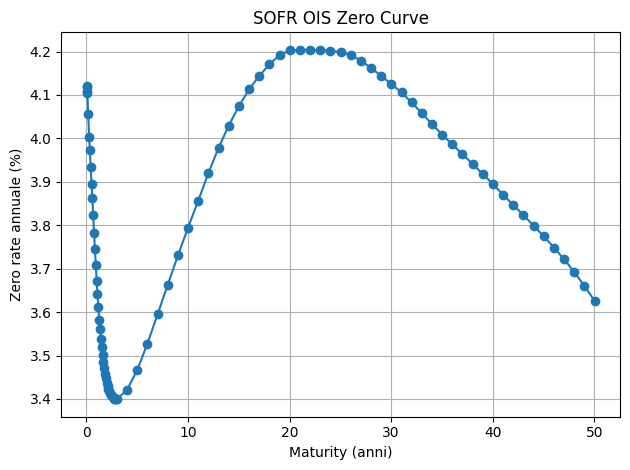

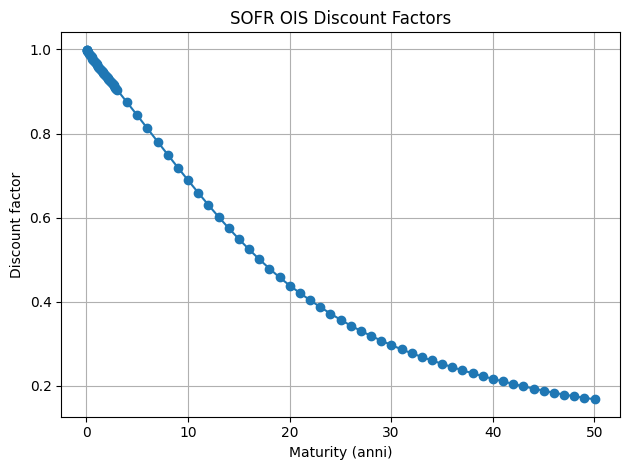

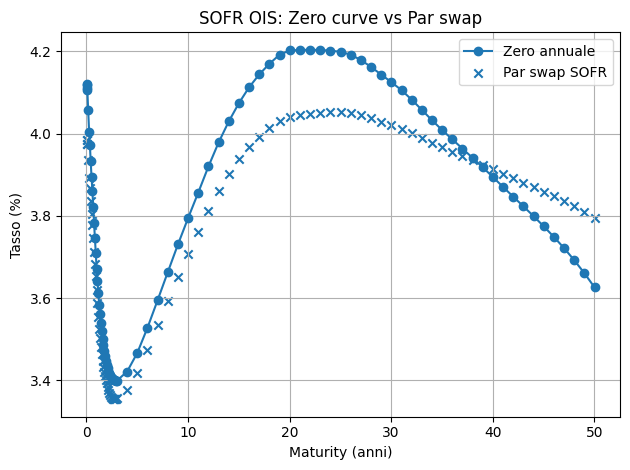

In [ ]:
# Yield curve: Zero_annual in %
plt.figure()
plt.plot(data["T_years"], data["Zero_annual"] * 100.0, marker="o")
plt.xlabel("Maturity (anni)")
plt.ylabel("Zero rate annuale (%)")
plt.title("SOFR OIS Zero Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

# Discount factors
plt.figure()
plt.plot(data["T_years"], data["DF"], marker="o")
plt.xlabel("Maturity (anni)")
plt.ylabel("Discount factor")
plt.title("SOFR OIS Discount Factors")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(data["T_years"], data["Zero_annual"]*100, marker="o", label="Zero annuale")
plt.scatter(data["T_years"], data["Rate"], marker="x", label="Par swap SOFR")
plt.xlabel("Maturity (anni)")
plt.ylabel("Tasso (%)")
plt.title("SOFR OIS: Zero curve vs Par swap")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
irs = IRS(
    effective=dt(2025, 11, 14),
    termination=dt(2025, 11, 21),
    notional=-1000000,
    fixed_rate=5.40,
    curves="sofr",
    spec="usd_irs",
)
irs.gamma(solver=solver).sum().sum()
irs.analytic_delta(curve=sofr)

irs.cashflows_table(solver=solver)
irs.cashflows(solver=solver)

,,Type,Period,Ccy,Acc Start,Acc End,Payment,Convention,DCF,Notional,DF,Collateral,Rate,Spread,Cashflow,NPV,FX Rate,NPV Ccy
leg1,0,FixedPeriod,Stub,USD,2025-11-14,2025-11-21,2025-11-25,act360,0.019444,-1000000.0,0.998786,None,5.40000,NaN,1050.00000,1048.725263,1.0,1048.725263
leg2,0,FloatPeriod,Stub,USD,2025-11-14,2025-11-21,2025-11-25,act360,0.019444,1000000.0,0.998786,None,3.98474,0.0,-774.81047,-773.869823,1.0,-773.869823


In [70]:
fixed = irs.leg1.periods[0]
floating = irs.leg2.periods[0]

vars(fixed)


{'fixed_rate': 5.4,
 'start': Timestamp('2025-11-14 00:00:00'),
 'end': Timestamp('2025-11-21 00:00:00'),
 'payment': Timestamp('2025-11-25 00:00:00'),
 'frequency': 'A',
 'notional': -1000000.0,
 'currency': 'usd',
 'convention': 'act360',
 'termination': datetime.datetime(2025, 11, 21, 0, 0),
 'freq_months': 12,
 'stub': True,
 'roll': 21,
 'calendar': <rateslib.rs.NamedCal at 0x110b78990>}

In [71]:
vars(floating)


{'float_spread': 0.0,
 'fixing_method': 'rfr_payment_delay',
 'method_param': 0,
 'spread_compound_method': 'none_simple',
 'fixings': <NoInput.blank: 0>,
 'start': Timestamp('2025-11-14 00:00:00'),
 'end': Timestamp('2025-11-21 00:00:00'),
 'payment': Timestamp('2025-11-25 00:00:00'),
 'frequency': 'A',
 'notional': 1000000.0,
 'currency': 'usd',
 'convention': 'act360',
 'termination': datetime.datetime(2025, 11, 21, 0, 0),
 'freq_months': 12,
 'stub': True,
 'roll': 21,
 'calendar': <rateslib.rs.NamedCal at 0x114f6c6f0>}

In [72]:
from rateslib.instruments import IRS

irs = IRS(effective=dt(2025,11,14), termination=dt(2030,11,14), spec="usd_irs")
print(irs.cashflows_table(solver=solver,curves=sofr))


local_ccy               USD
collateral_ccy          NaN
payment                    
2026-11-18      2070.320782
2027-11-17     -2628.121553
2028-11-16     -1411.329165
2029-11-16       220.536474
2030-11-18      1830.608097


In [73]:
cf = irs.cashflows(solver=solver,curves=sofr)
print(cf)


               Type   Period  Ccy  Acc Start    Acc End    Payment Convention  \
leg1 0  FixedPeriod  Regular  USD 2025-11-14 2026-11-16 2026-11-18     act360   
     1  FixedPeriod  Regular  USD 2026-11-16 2027-11-15 2027-11-17     act360   
     2  FixedPeriod  Regular  USD 2027-11-15 2028-11-14 2028-11-16     act360   
     3  FixedPeriod  Regular  USD 2028-11-14 2029-11-14 2029-11-16     act360   
     4  FixedPeriod  Regular  USD 2029-11-14 2030-11-14 2030-11-18     act360   
leg2 0  FloatPeriod  Regular  USD 2025-11-14 2026-11-16 2026-11-18     act360   
     1  FloatPeriod  Regular  USD 2026-11-16 2027-11-15 2027-11-17     act360   
     2  FloatPeriod  Regular  USD 2027-11-15 2028-11-14 2028-11-16     act360   
     3  FloatPeriod  Regular  USD 2028-11-14 2029-11-14 2029-11-16     act360   
     4  FloatPeriod  Regular  USD 2029-11-14 2030-11-14 2030-11-18     act360   

             DCF   Notional        DF Collateral      Rate  Spread  \
leg1 0  1.019444  1000000.0  0.964232 

In [74]:
import numpy as np
import pandas as pd
from pandas import DataFrame, option_context
from rateslib import dt, add_tenor
from rateslib.curves import Curve
from rateslib.instruments import IRS
from rateslib.solver import Solver
from pathlib import Path

repo_root = Path.cwd()
csv_path = repo_root / "SOFR_panel_Date_Tenor_Rate_sorted.csv"

panel_long = pd.read_csv(csv_path, parse_dates=["Date"])
panel_long["Date"] = panel_long["Date"].dt.date

def sofr_curve(date_):
    if isinstance(date_, str):
        date_ = pd.to_datetime(date_).date()
    elif isinstance(date_, pd.Timestamp):
        date_ = date_.date()
    return panel_long[panel_long["Date"] == date_].reset_index(drop=True)

def build_zero_curve(date_):
    data = sofr_curve(date_)

    terms = data["Tenor"].astype(str).tolist()
    rates = data["Rate"].astype(float).tolist()

    base_date = dt(*pd.to_datetime(date_).date().timetuple()[:3])

    data["Termination"] = [add_tenor(base_date, t, "F", "nyc") for t in terms]

    sofr = Curve(
        id="sofr",
        convention="Act360",
        calendar="nyc",
        modifier="MF",
        interpolation="log_linear",
        nodes={base_date: 1.0, **{dd: 1.0 for dd in data["Termination"]}},
    )

    solver = Solver(
        curves=[sofr],
        instruments=[IRS(base_date, dd, spec="usd_irs", curves="sofr") for dd in data["Termination"]],
        s=rates,
        instrument_labels=terms,
    )

    data["DF"] = [float(sofr[dd]) for dd in data["Termination"]]
    data["T_years"] = (data["Termination"] - base_date).dt.days / 365.0

    data["Zero_cc"] = -np.log(data["DF"]) / data["T_years"]
    data["Zero_annual"] = np.exp(data["Zero_cc"]) - 1.0

    return data[["T_years", "Zero_annual"]]
all_dates = sorted(panel_long["Date"].unique())

curves = []        # matrice (una riga per data)
tenor_grid = None  # la prendiamo dalla prima curva

for d in all_dates:
    curve = build_zero_curve(d)

    if tenor_grid is None:
        tenor_grid = curve["T_years"].values

    curves.append(curve["Zero_annual"].values)
import numpy as np

Z = np.array(curves) * 100.0   # convertiamo in percento
X = tenor_grid
Y = np.array(all_dates, dtype=str)
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Surface(
            z=Z,
            x=X,
            y=Y,
            colorscale="Viridis",
            showscale=True
        )
    ]
)

fig.update_layout(
    title="SOFR OIS Yield Curve Surface",
    scene=dict(
        xaxis_title="Tenor (years)",
        yaxis_title="Date",
        zaxis_title="Zero annual rate (%)",
        xaxis=dict(nticks=10),
        yaxis=dict(type="category"),
    ),
    width=900,
    height=700,
)

fig.show()


SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 3.178559934680021e-16, `time`: 0.4462s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 5.769201181333797e-16, `time`: 0.4550s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 7.053640826104959e-16, `time`: 0.4516s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 6.966048277616918e-16, `time`: 0.4563s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 2.8126841850387443e-16, `time`: 0.4728s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 2.3473197922350706e-16, `time`: 0.4618s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 3.992181040456609e-16, `time`: 0.4770s
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 4.920132457766295e-16, `time`: 0.4641s
SUCCESS: `func_tol` reached after 7 iterations (levenb